In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra

In [2]:
corpus = pra.datasets.CMUArcticCorpus(download=True, speaker=['bdl'])
sample = corpus.samples[0]

clean = sample.data
fs = sample.fs

In [3]:
corners = np.array([[0, 0], [0, 3], [5, 3], [5, 1], [3, 1], [3, 0]]).T  # [x,y] in metres
room = pra.Room.from_corners(corners, fs=sample.fs, ray_tracing=True,
                             air_absorption=True, materials=pra.Material(0.2, 0.15))

In [4]:
room.add_source([1.5, 1.5], signal=sample.data)

In [14]:
R = np.array([[1, 2, 1.5], [1, 1., 2]])  # [[x], [y], [z]]
print(R)

M1 = R[:,0]
M2 = R[:,1]
M3 = R[:,2]
print(M3)

[[1.  2.  1.5]
 [1.  1.  2. ]]
[1.5 2. ]


In [15]:
room.add_microphone(R)

(0.0, 3.0)

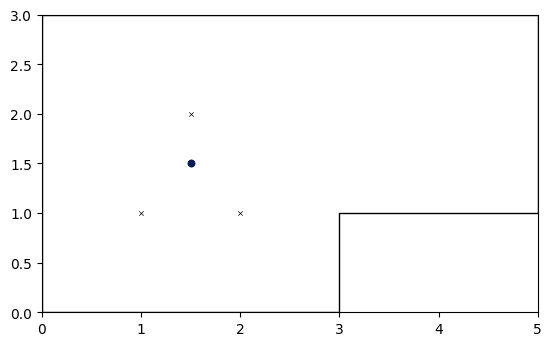

In [16]:
fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])

(<Figure size 640x480 with 3 Axes>,
 array([[<Axes: title={'center': 'Source 0'}>],
        [<Axes: >],
        [<Axes: xlabel='Time (ms)'>]], dtype=object))

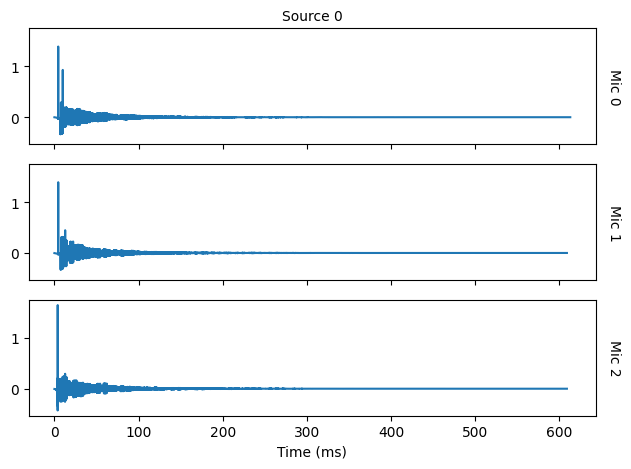

In [17]:
room.compute_rir()

room.plot_rir()

In [18]:
room.simulate()
print(room.mic_array.signals.shape)

(3, 61570)


In [19]:
x1 = room.mic_array.signals[0, :]
x2 = room.mic_array.signals[1, :]
x3 = room.mic_array.signals[2, :]

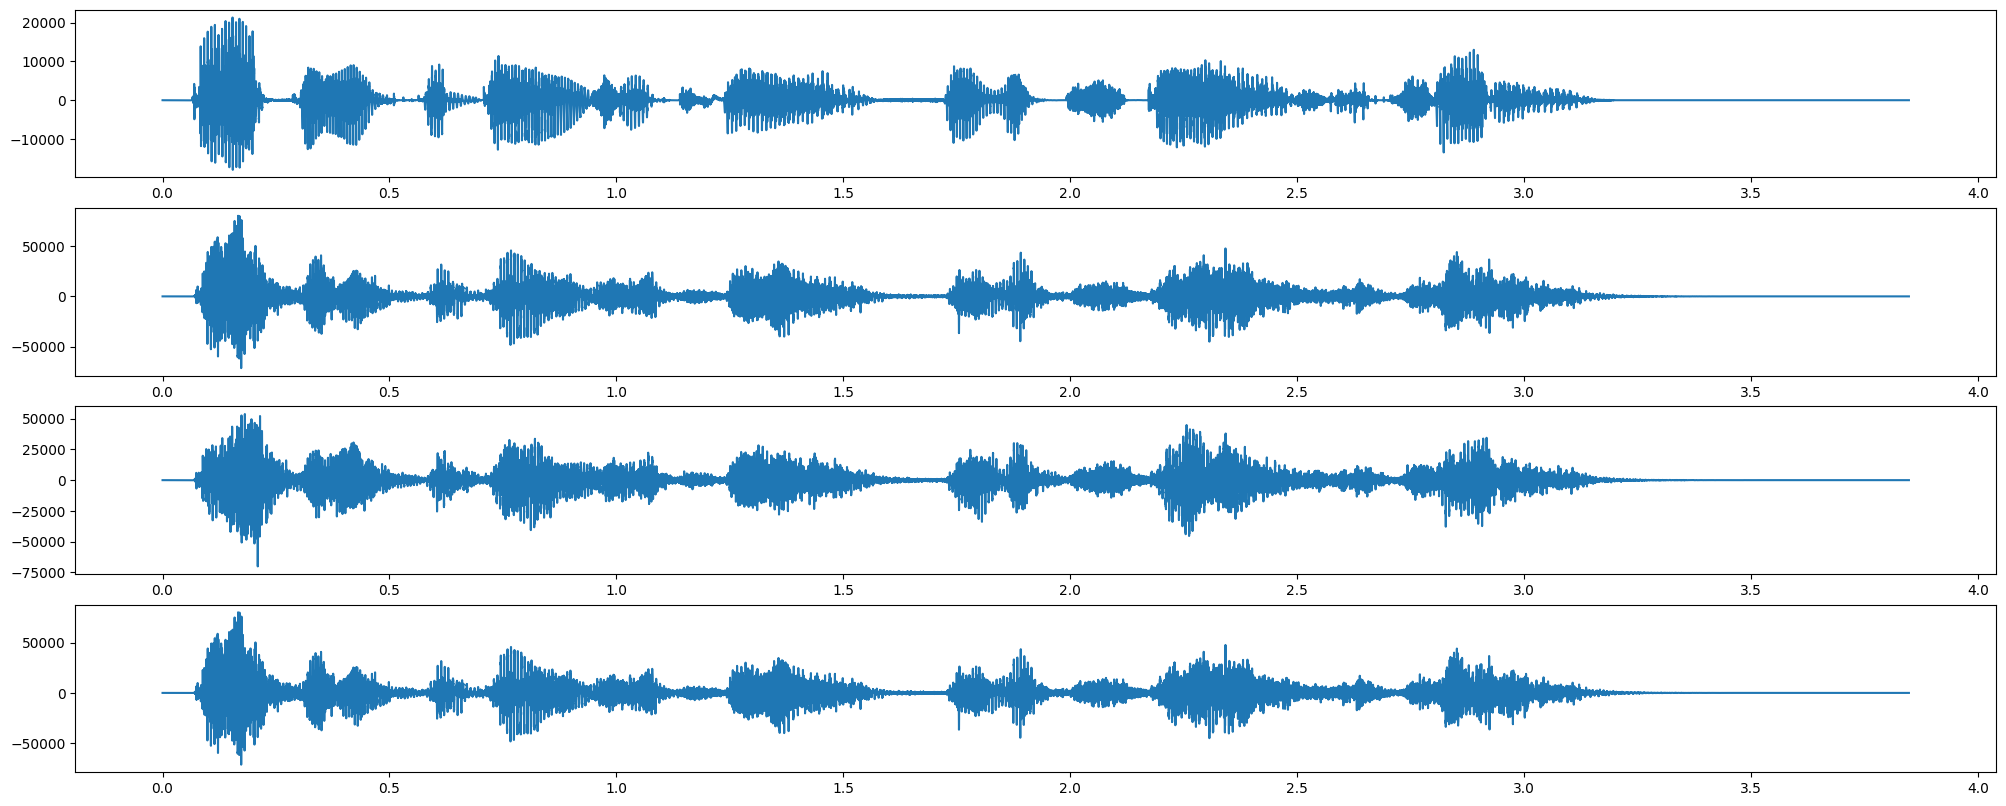

In [20]:
N = max(len(sample.data), len(x1))
t = np.arange(N) / sample.fs

if len(x1) < N:
    x1 = np.concatenate((x1, np.zeros(N - len(x1))))
if len(sample.data) < N:
    signal = np.concatenate((sample.data, np.zeros(N - len(sample.data))))
else:
    signal = sample.data

fig = plt.figure()
fig.set_size_inches(20, 8)
plt.subplot(4, 1, 1)
plt.plot(t, signal)
plt.subplot(4, 1, 2)
plt.plot(t, x1)
plt.subplot(4, 1, 3)
plt.plot(t, x2)
plt.subplot(4, 1, 4)
plt.plot(t, x1)
plt.tight_layout(pad=0.5)

In [21]:

# get energy
T = int(fs * 0.02)   # 200 ms
T = len(x1)
y1 = np.zeros(len(x1)//T)
y2 = np.zeros(len(x2)//T)
y3 = np.zeros(len(x3)//T)

for l in range(0, len(y1)):
    y1[l] = np.mean(x1[l * T: (l + 1) * T] ** 2)
    y2[l] = np.mean(x2[l * T: (l + 1) * T] ** 2)
    y3[l] = np.mean(x3[l * T: (l + 1) * T] ** 2)

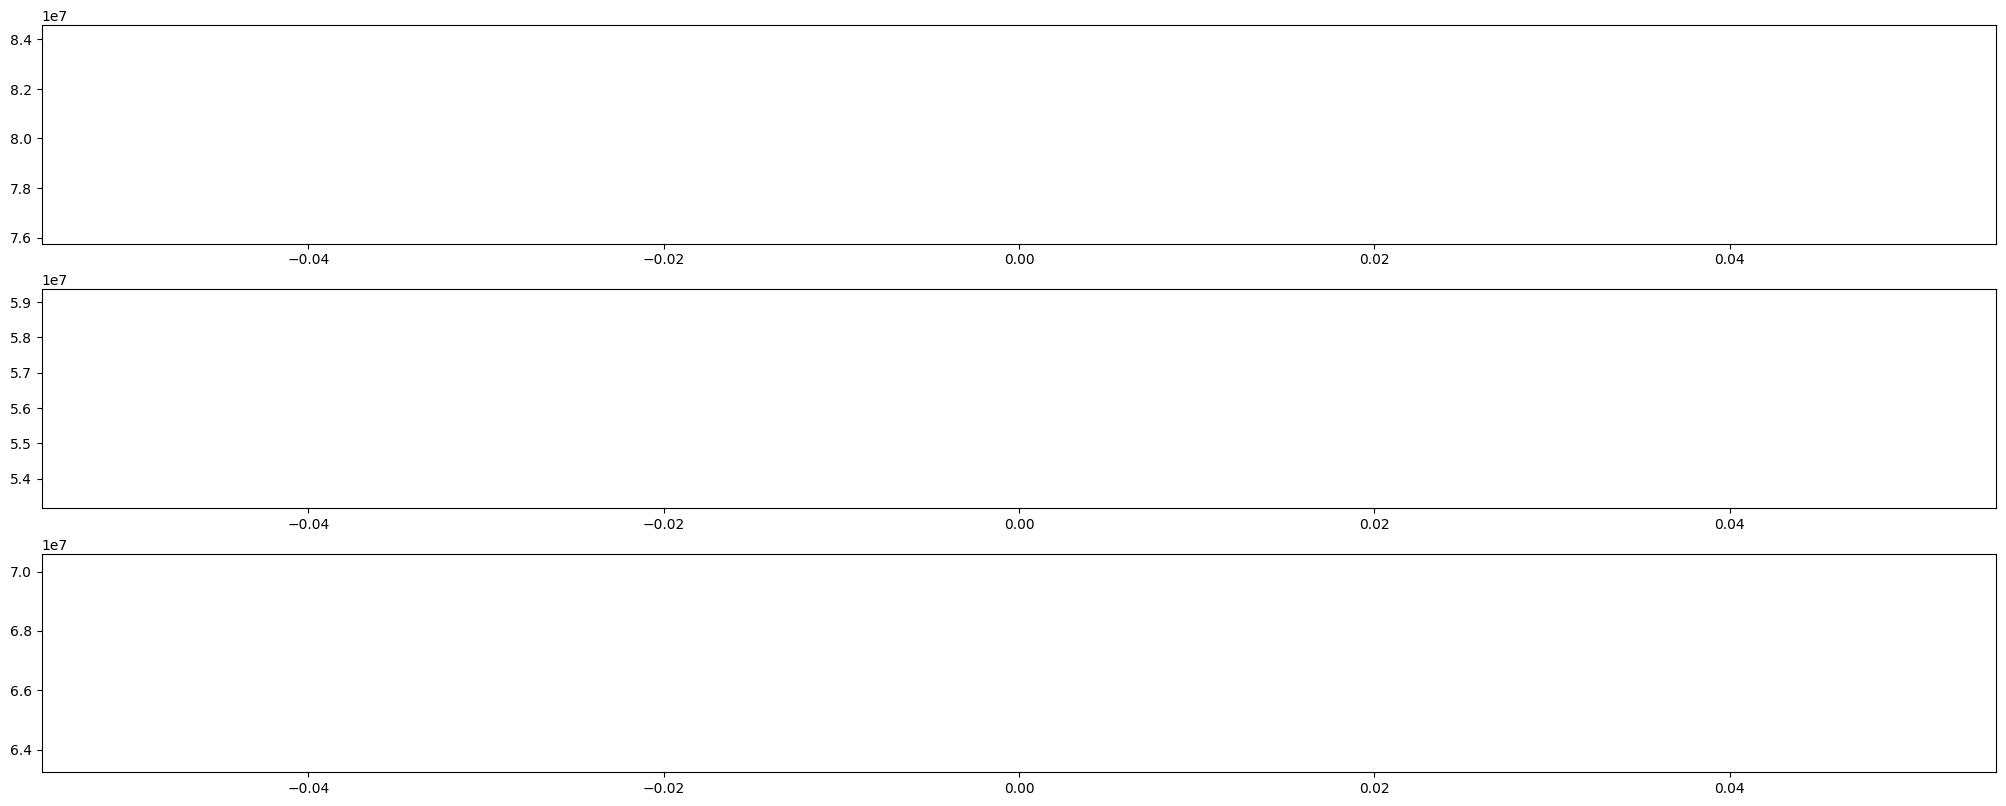

In [22]:
t_energy = np.arange(len(y1)) / fs

fig = plt.figure()
fig.set_size_inches(20, 8)
plt.subplot(3, 1, 1)
plt.plot(t_energy, y1)
plt.subplot(3, 1, 2)
plt.plot(t_energy, y2)
plt.subplot(3, 1, 3)
plt.plot(t_energy, y3)
plt.tight_layout(pad=0.5)

In [23]:
kappa_12 = ((y1/y2) / (1) ) ** (-1/2)
kappa_13 = ((y1/y3) / (1) ) ** (-1/2)
kappa_23 = ((y2/y3) / (1) ) ** (-1/2)
kappa_21 = 1/kappa_12
kappa_31 = 1/kappa_13
kappa_32 = 1/kappa_23

print(kappa_12)
print(kappa_13)
print(kappa_23)

[0.83777066]
[0.91363537]
[1.09055546]


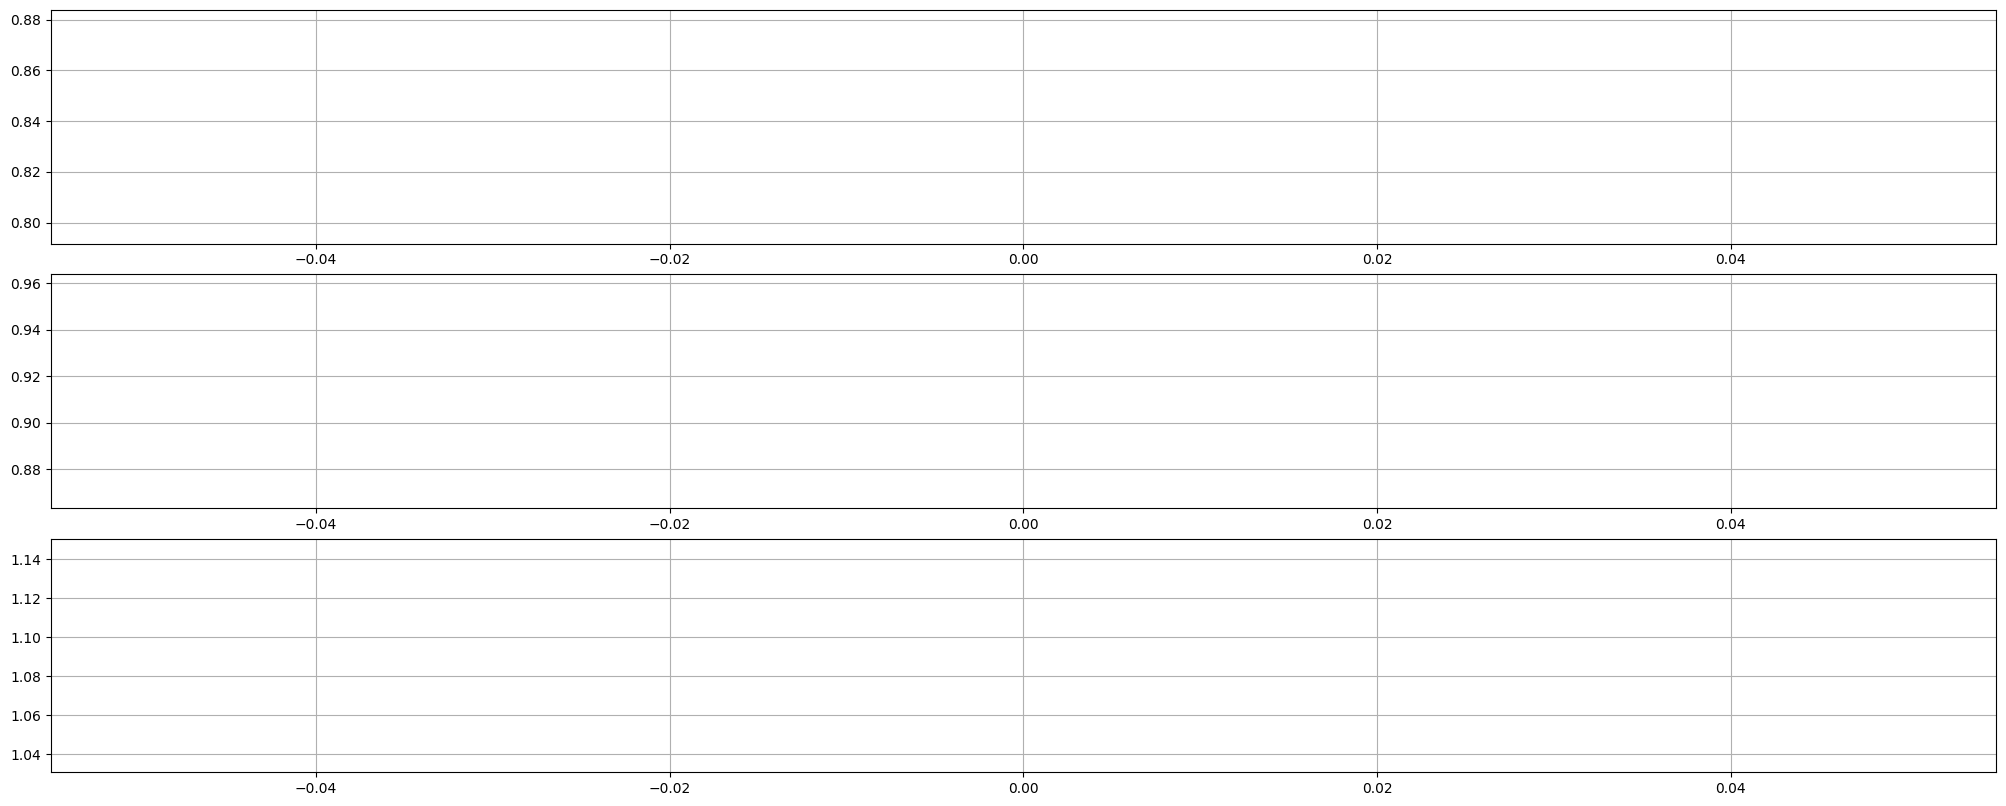

In [24]:
t_energy = np.arange(len(y1)) / fs

fig = plt.figure()
fig.set_size_inches(20, 8)
plt.subplot(3, 1, 1)
plt.plot(t_energy, kappa_12)
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(t_energy, kappa_13)
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(t_energy, kappa_23)
plt.grid()
plt.tight_layout(pad=0.5)

In [30]:
def norm(x: np.ndarray):
    return np.sqrt(x[0]**2 + x[1]**2)

In [55]:
# Hyperspheres

c12 = (M1 - kappa_12**2 * M2) / (1-kappa_12**2)
c13 = (M1 - kappa_13**2 * M3) / (1-kappa_13**2)
c23 = (M3 - kappa_32**2 * M2) / (1-kappa_32**2)

Q12 = kappa_12 * norm(M1 - M2) / (1-kappa_12**2)
Q13 = kappa_13 * norm(M2 - M3) / (1-kappa_13**2)
Q23 = kappa_32 * norm(M2 - M3) / (1-kappa_32**2)

print(c12)
print(c13)
print(c23)

print(Q12)
print(Q13)
print(Q23)

[-1.35412533  1.        ]
[-1.52534478 -4.05068956]
[-1.14115377  7.28230755]
[2.8099878]
[6.18063049]
[6.44060173]


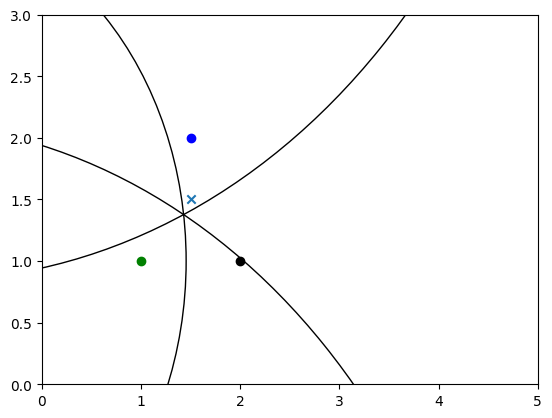

In [57]:
fig, ax = plt.subplots(1,1)
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
plt.scatter(M1[0], M1[1], c="g")
plt.scatter(M2[0], M2[1], c="k")
plt.scatter(M3[0], M3[1], c="b")
plt.scatter(1.5, 1.5, marker="x")
circle1 = plt.Circle(c12, Q12, fill=False)
circle2 = plt.Circle(c13, Q13, fill=False)
circle3 = plt.Circle(c23, Q23, fill=False)

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

In [9]:
## find location: gradient descent with cost function defined in paper

## or.. use eq (11)


## see Weighted Least-Squares Solutions for Energy-Based Collaborative Source Localization Using Acoustic Array
# for description on how to get the least squares solution